## MCMC with BlackJAX

Try to get a Gibbs sampler working in BlackJAX as documented [here](https://github.com/blackjax-devs/blackjax/discussions/275#discussioncomment-3665608).

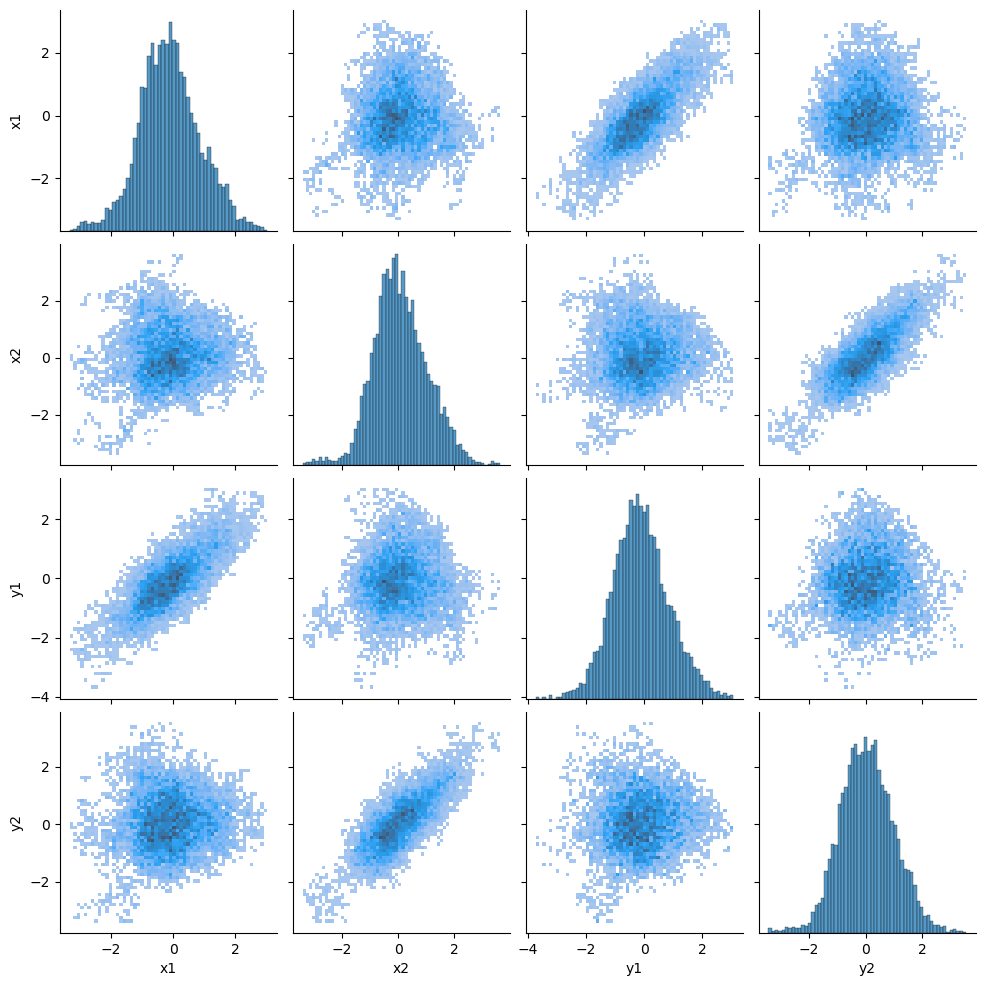

In [1]:
# example of a Gibbs kernel on two blocks of RMH kernels

import numpy as np
import jax 
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random
import blackjax
import pandas as pd
import seaborn as sns

def logprob_fn(x, y, Sigma):
    """
    Log-pdf of (x, y) ~ Normal(0, Sigma)
    """
    z = jnp.concatenate([x, y])
    return jsp.stats.multivariate_normal.logpdf(z, mean=jnp.zeros_like(z), cov=Sigma)


# example with x.shape == y.shape == (2,)
Sigma = jnp.array([
    [1., 0., .8, 0.],
    [0., 1., 0., .8],
    [.8, 0., 1., 0.],
    [0., .8, 0., 1.]
])

def logprob(params): 
    return logprob_fn(Sigma=Sigma, **params)

# initial state
initial_position = {"x": jnp.array([0., 0.]), "y": jnp.array([.1, .1])}
initial_state = blackjax.mcmc.rmh.init(initial_position, logprob)

# now the gibbs kernel function
rmh_step_fn = blackjax.mcmc.rmh.kernel()
rmh_state_ctor = blackjax.mcmc.rmh.RMHState

def gibbs_kernel(rng_key, state, sigma_x, sigma_y):
    """
    Gibbs kernel on x and y each by RMH with covariances sigma_x and sigma_y.
    """
    # setup
    key_x, key_y = jax.random.split(rng_key, num=2)
    position = {"x": state.position["x"], "y": state.position["y"]}
    log_probability = state.log_probability

    # x step
    # need to create a partial state for updating just x,
    # otherwise rmh_step_fn infers wrong dimension for proposal
    state_x = rmh_state_ctor(position["x"], log_probability)
    def logprob_x(x): return logprob({"x": x, "y": position["y"]})
    state_x, _ = rmh_step_fn(
        rng_key=key_x,
        state=state_x,
        logprob_fn=logprob_x,
        sigma=sigma_x
    )
    position["x"] = state_x.position
    # need a common log_probability for the draws,
    # otherwise could have written gibbs_kernel 
    # with separate arguments state_x and state_y
    log_probability = state_x.log_probability 

    # y step
    state_y = rmh_state_ctor(position["y"], log_probability)
    def logprob_y(y): return logprob({"x": position["x"], "y": y})
    state_y, _ = rmh_step_fn(
        rng_key=key_y,
        state=state_y,
        logprob_fn=logprob_y,
        sigma=sigma_y
    )
    position["y"] = state_y.position
    log_probability = state_y.log_probability

    return rmh_state_ctor(position, log_probability)


# sample from the posterior
sigma_x = .2 * jnp.eye(2)
sigma_y = .3 * jnp.eye(2)

def inference_loop(rng_key, initial_state, num_samples, sigma_x, sigma_y):
    @jax.jit
    def one_step(state, rng_key):
        state = gibbs_kernel(rng_key, state, sigma_x, sigma_y)
        return state, state

    keys = jax.random.split(rng_key, num_samples)
    _, states = jax.lax.scan(one_step, initial_state, keys)

    return states

rng_key = jax.random.PRNGKey(0)
states = inference_loop(
    rng_key = rng_key,
    initial_state = initial_state,
    num_samples = 10000,
    sigma_x = sigma_x,
    sigma_y = sigma_y
)


# plot samples
data = pd.DataFrame({
    "x1": states.position["x"][:,0],
    "x2": states.position["x"][:,1],
    "y1": states.position["y"][:,0],
    "y2": states.position["y"][:,1]
})

sns.pairplot(data, kind="hist")